## Prototype for Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the performance of a new prototype method to calibrate lower confidence bounds for survival times under right-censoring.
This method used imputation of unobserved censoring times to obtain an artificial data set with type-I censoring, and then applies Candes' method.
The methods are implemented in the accompanying "utils" R scripts.

In [80]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)

## Generate some survival data

In [195]:
# Generate data from the Log-normal model (Mvt + Heterosc.) of Candes et al. (Table 1)
source("../conf_surv/utils_data_new.R")

setting = 1

if(setting==1) {    
    # Initialize the covariate model
    covariate_generator <- function(num_samples) {
        num_features = 20
        matrix(runif(num_samples * num_features, 0, 1), nrow = num_samples)
    }

    # Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + X[,1]^0.25
    surv_sigma_fun <- function(X) 0*X[,1] + 0.1
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)

    # Initialize the censoring time distribution
    cens_mu_fun <- function(X) 0*X[,1] + X[,1] + 0.2
    cens_sigma_fun <- function(X) 0*X[,1] + 0.1
    censoring_generator <- LogNormalDistribution$new(mu_fun = cens_mu_fun, sigma_fun = cens_sigma_fun)
    
    num_samples_train <- 200
    
} else if(setting==3) {    
    
    # Initialize the covariate model
    covariate_generator <- function(num_samples) {
        num_features = 10
        matrix(runif(num_samples * num_features, 0, 4), nrow = num_samples)
    }
    
    # Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + 2 * (X[,1]>2) + X[,1] * (X[,1]<2)
    surv_sigma_fun <- function(X) 0*X[,1] + 0.5
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)

    # Initialize the censoring time distribution
    cens_rate_fun <- function(X) 0*X[,1] + 0.25 + (6+X[,1])/100
    censoring_generator <- ExponentialDistribution$new(rate_fun = cens_rate_fun)
    
    num_samples_train <- 200
    
} else if(setting==4) {    
    
    # Initialize the covariate model
    covariate_generator <- function(num_samples) {
        num_features = 10
        matrix(runif(num_samples * num_features, 0, 4), nrow = num_samples)
    }

    # Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + 3 * (X[,1]>2) + 1.5 * X[,1] * (X[,1]<2)
    surv_sigma_fun <- function(X) 0*X[,1] + 0.5
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)

    # Initialize the censoring time distribution
    cens_mu_fun <- function(X) 0*X[,1] + 2 + (2-X[,1])/50
    cens_sigma_fun <- function(X) 0*X[,1] + 0.5
    censoring_generator <- LogNormalDistribution$new(mu_fun = cens_mu_fun, sigma_fun = cens_sigma_fun)

    num_samples_train <- 200
}

# Initialize the data generator
generator <- SurvivalDataGenerator$new(covariate_generator, survival_generator, censoring_generator)


# Sample sizes
num_samples_cal <- 1000
num_samples_test <- 500


# Set random seet
set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generator$sample(num_samples_train)
data.cal.oracle <- generator$sample(num_samples_cal)
data.test.oracle <- generator$sample(num_samples_test)

# Remove true event and censoring times from the data (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Remove only true event times from the data (type-I censoring)
data.train.t1 <- data.train.oracle |> select(-event_time)
data.cal.t1 <- data.cal.oracle |> select(-event_time)
data.test.t1 <- data.test.oracle |> select(-event_time)

#generator$predict_quantiles(select(data.test, -time, -status)[c(24),], T.max=1000)

## Visualize the true (oracle) data distribution

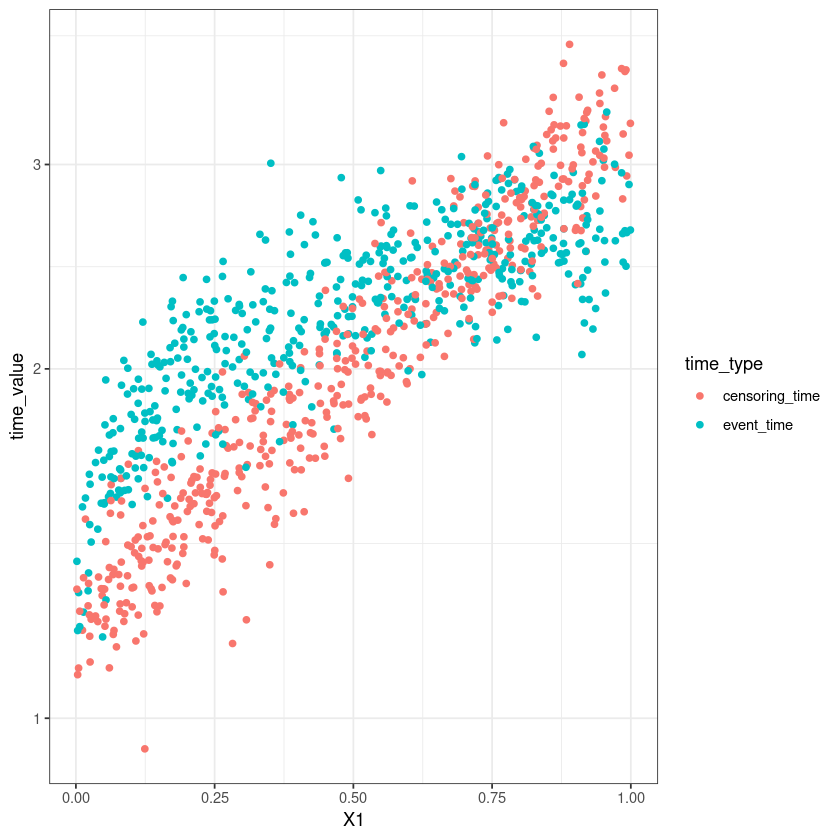

In [196]:
data.test.oracle |>
    select(X1, event_time, censoring_time) |>
    pivot_longer(cols = c(event_time, censoring_time), 
                 names_to = "time_type", values_to = "time_value") |>
    ggplot(aes(x=X1, y=time_value, color=time_type)) +
    geom_point() +
    scale_y_continuous(trans='log10') +
    theme_bw()

In [197]:
source("../conf_surv/utils_conformal.R")

alpha = 0.1

pred.oracle.fast <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle.fast,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
0.47,1.973185,2.034802,1.973905,2.038244,0.918,NA


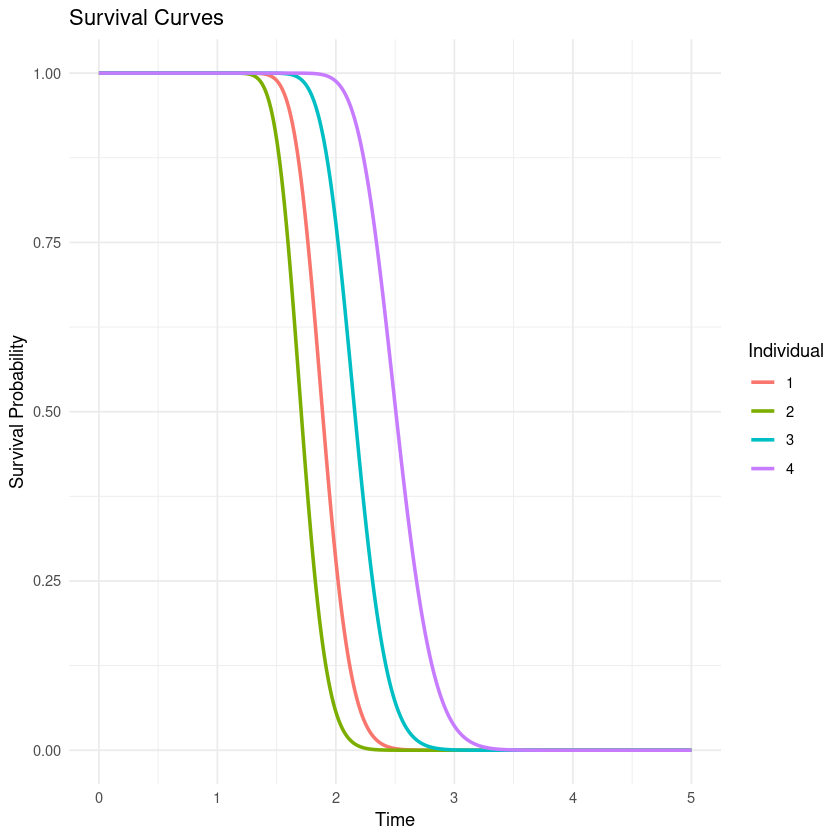

In [198]:
# Plot the survival curves

source("../conf_surv/utils_plotting_new.R")
predictions.surv = generator$survival$predict(data.test[1:4,], seq(0,5, length.out=1000))
plot_survival_curves(predictions.surv)

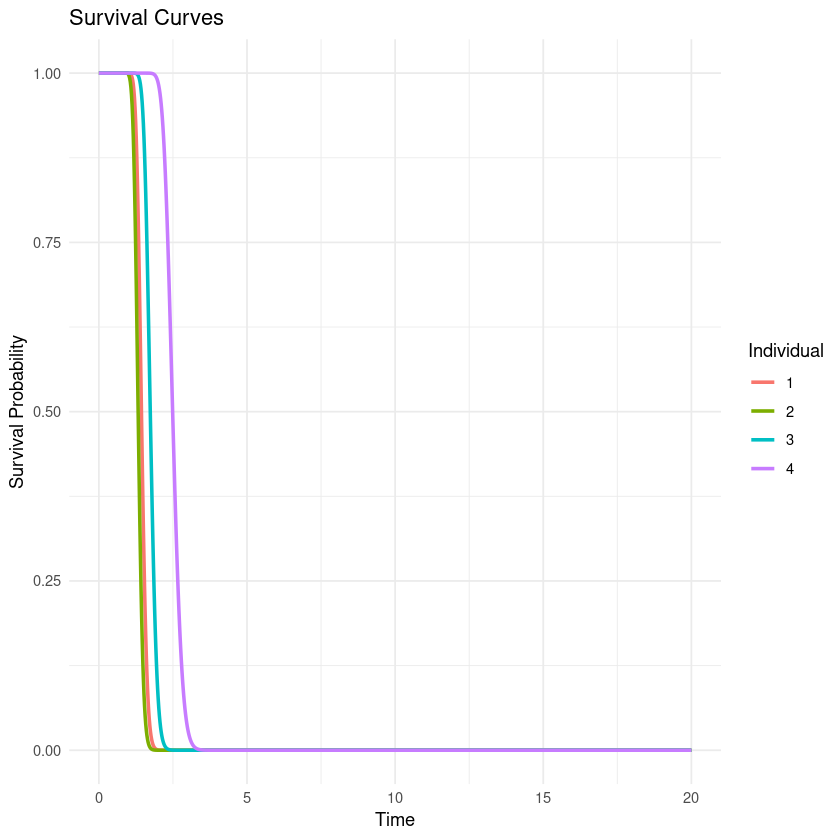

In [199]:
# Plot the censoring curves

source("../conf_surv/utils_plotting_new.R")
predictions.censor = generator$censoring$predict(data.test[1:4,], seq(0,20, length.out=1000))
plot_survival_curves(predictions.censor)

## Explore the data

Let's take a look at the data

In [200]:
# Summarize data under type-I censoring
data.train.oracle |>
    summarise(Observations=n(), Events = sum(status), 
              `Proportion censored`=mean(status==0),
              `Median event time`=median(event_time),
              `Mean event time`=mean(event_time),
              `Median censoring time`=median(censoring_time),
              `Mean censoring time`=mean(censoring_time),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]),
              `Median censoring time` = median(censoring_time))

Observations,Events,Proportion censored,Median event time,Mean event time,Median censoring time,Mean censoring time,Median observed time,Median observed event time
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,59,0.705,2.278564,2.239235,1.974679,2.080494,1.960909,2.879644


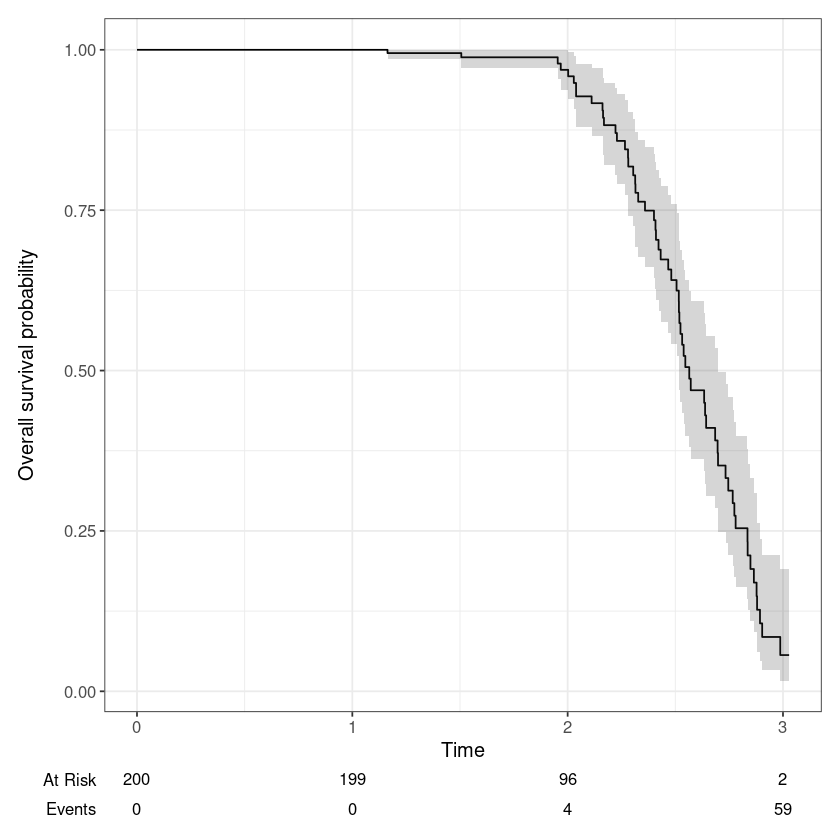

In [201]:
# Kaplan-Meier plot
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Fit survival model

Fit a survival model using the training data.

In [202]:
source("../conf_surv/utils_survival_new.R")

model_type = "cox"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="lognormal")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else if (model_type=="cox") {
    # Instantiate random forest survival model
    surv_model <- CoxphModelWrapper$new()
} else {
    stop("Unknown model type!")
}

## Visualize the model's predictions

Visualize the predicted survival curves for two individuals.

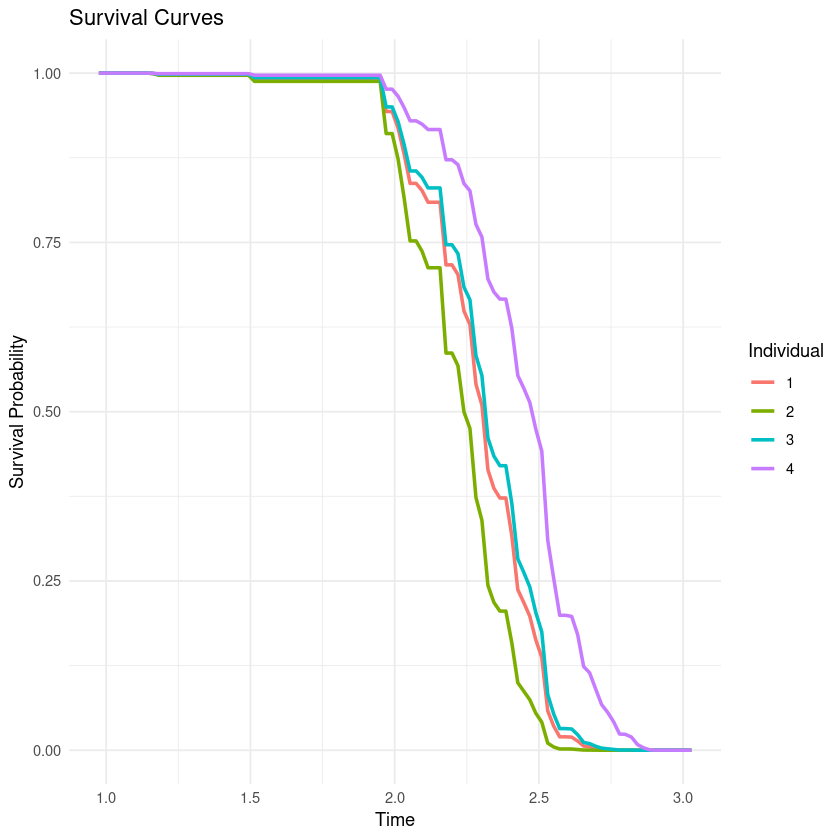

In [203]:
surv_model$fit(Surv(time, status) ~ ., data = data.train)

idx.predict <- c(1:4)

predictions = surv_model$predict(data.cal[idx.predict,])
plot_survival_curves(predictions)

Predict survival time quantiles

In [204]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,2.032712,2.323154,2.530613
Individual_2,2.011966,2.240170,2.426883
Individual_3,2.032712,2.323154,2.530613
Individual_4,2.177933,2.489121,2.696580


## Estimating the censoring distribution

Let's start by visualizing the true censoring distribution

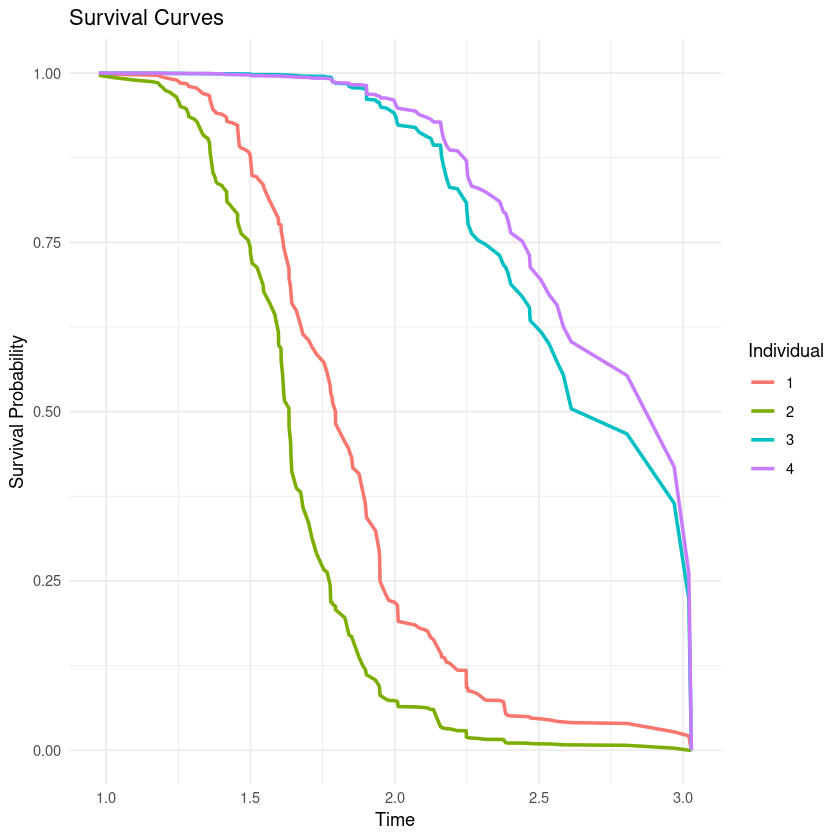

In [205]:
source("../conf_surv/utils_censoring.R")
source("../conf_surv/utils_survival_new.R")

# Initialize a base model for the censoring distribution
cens_base_model <- GRF_SurvivalForestWrapper$new()
#cens_base_model <- SurvregModelWrapper$new(dist="lognormal")
#cens_base_model <- CoxphModelWrapper$new()

# Create an instance of the CensoringModel class with the model
censoring_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
censoring_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1:4)
pred_surv = censoring_model$model$predict(data.cal[idx.predict,])
plot_survival_curves(pred_surv)

## Oracle prediction bounds

In [206]:
source("../conf_surv/utils_conformal.R")

alpha = 0.1

pred.oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle,
                event_time=data.test.oracle$event_time,
                oracle = pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.47,1.973185,2.034802,1.973905,2.038244,0.918,0


## Naive CQR

In [207]:
source("../conf_surv/utils_conformal.R")

alpha = 0.1
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.894,1.487098,1.405443,1.488888,1.405443,0.988,0.2756202


## Nominal lower bound

In [208]:
alpha = 0.1
pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.nominal,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.374,2.135113,2.053458,2.161093,2.177933,0.648,0.06556121


## CQR with de-censoring

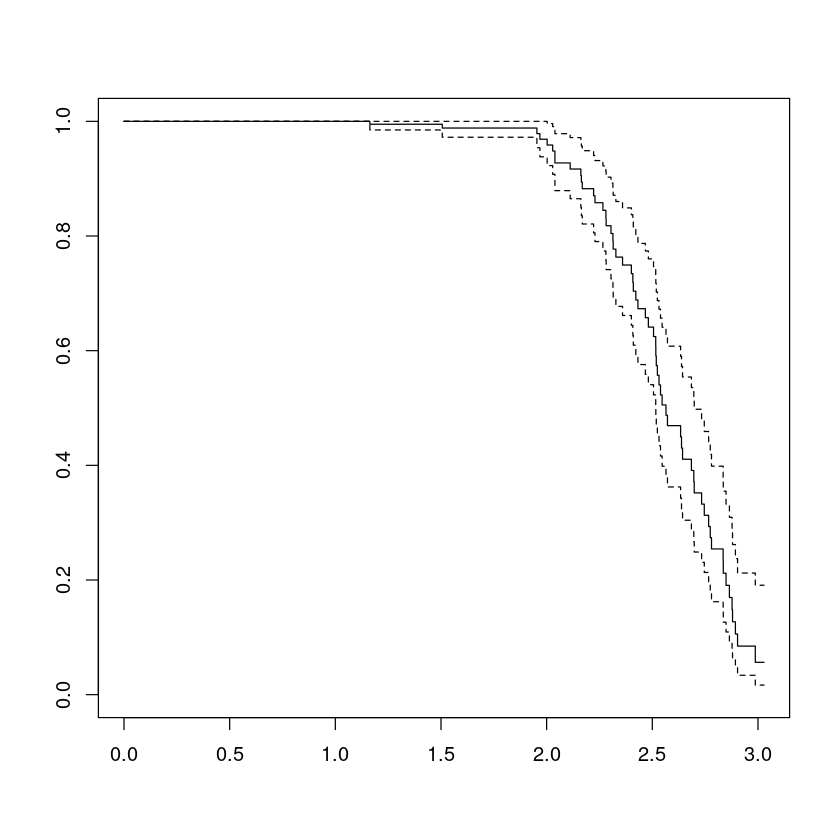

In [209]:
## Create a survival object
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)

## Fit the Kaplan-Meier survival model
km_fit <- survfit(surv_object ~ 1)

## Plot the Kaplan-Meier survival curve
plot(km_fit)

In [210]:
source("../conf_surv/utils_decensoring.R")

pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test.oracle$time, 
                pred.decensor,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.426,2.089906,2.00825,2.119486,2.132725,0.702,0.05296418


## Gui's method (with oracle censoring times, and oracle weights)

[1] 4


Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.544,1.942467,1.970474,1.941125,1.970474,0.844,0.04383157


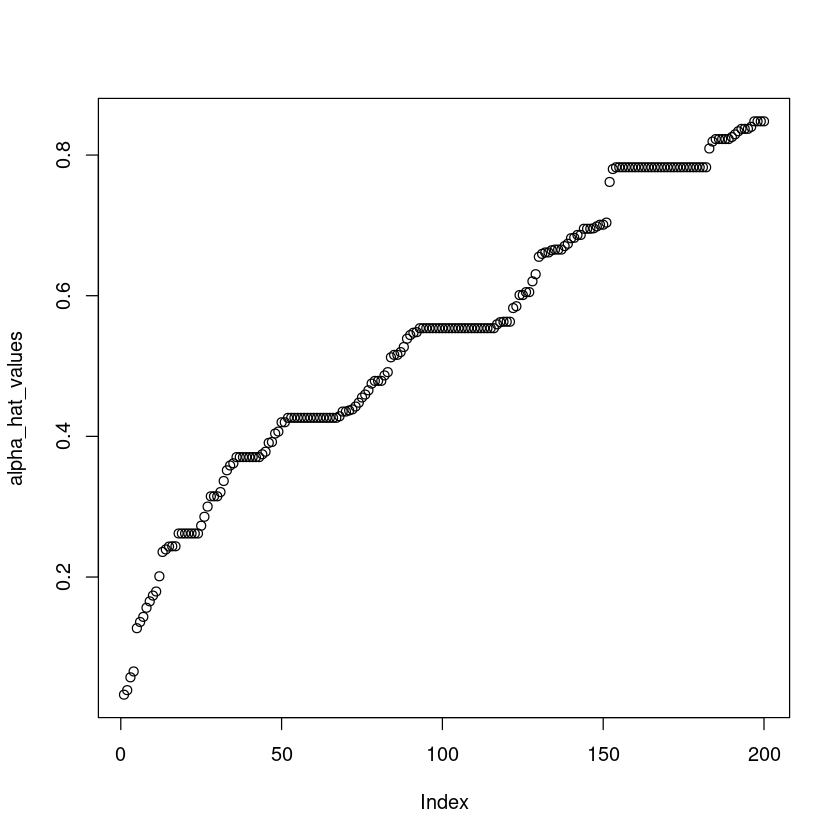

In [217]:
source("../conf_surv/utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

pred.gui <- predict_Gui(data.test, surv_model, generator$censoring, data.cal, C.cal, alpha, use_cqr=FALSE, use_censoring_model=FALSE)

evaluate_bounds(data.test.oracle$time, 
                pred.gui,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

[1] 157


Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.738,1.673757,1.609746,1.678273,1.642272,0.964,0.1336952


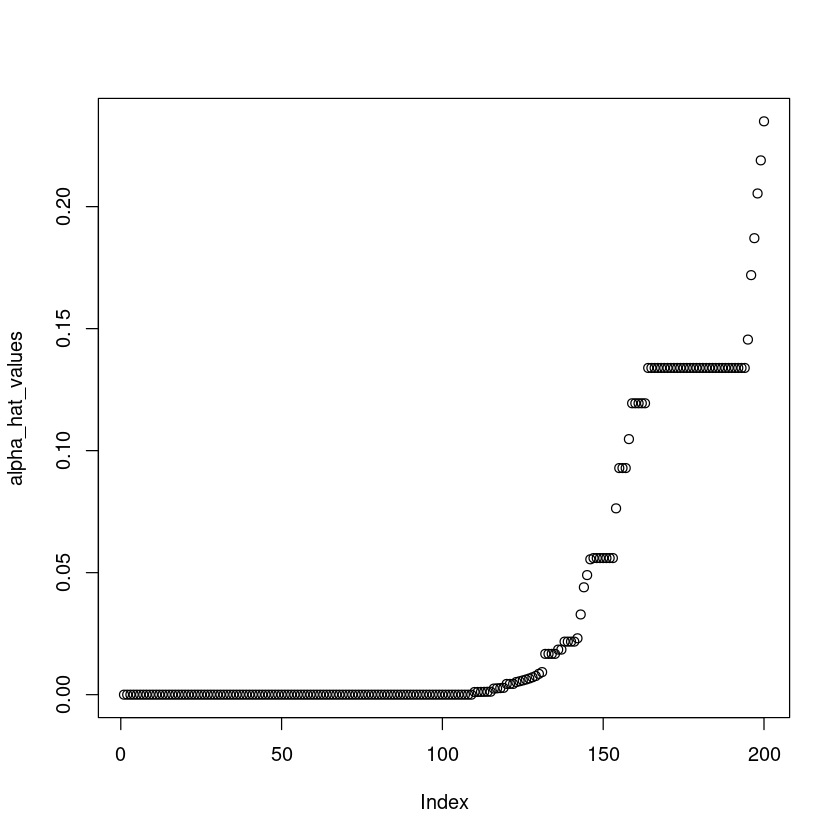

In [215]:
source("../conf_surv/utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

pred.gui <- predict_Gui(data.test, surv_model, generator$censoring, data.cal, C.cal, alpha, use_cqr=TRUE, use_censoring_model=FALSE)

evaluate_bounds(data.test.oracle$time, 
                pred.gui,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

## Candes' method (with oracle censoring times, and oracle weights)

In [71]:
source("../conf_surv/utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

pred.candes <- predict_Candes(data.test, surv_model, generator$censoring, data.cal, C.cal, alpha)

evaluate_bounds(data.test.oracle$time, 
                pred.candes,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.546,1.856536,1.994867,1.870245,1.994867,0.926,0.02725492


In [20]:
source("../conf_surv/utils_conformal.R")

# Apply Candes' method with automatic tuning of c0
tuning.package <- list(data.train = data.train,
                       C.train = data.train.oracle$censoring_time)

pred.candes.tuned <- predict_Candes(data.test, surv_model, generator$censoring, data.cal, C.cal, alpha, 
                                    tuning.package=tuning.package)

evaluate_bounds(data.test.oracle$time, 
                pred.candes.tuned,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.818,1.309431,1.964994,1.289533,1.964994,0.97,0.9080529


## Candes' method (with oracle censoring times, and estimated weights)

In [21]:
source("../conf_surv/utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

pred.candes <- predict_Candes(data.test, surv_model, censoring_model$model, data.cal, C.cal, alpha)

evaluate_bounds(data.test.oracle$time, 
                pred.candes,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.686,1.567504,1.964533,1.53521,1.964533,0.922,0.4906377


In [22]:
source("../conf_surv/utils_conformal.R")

# Tune c0
pred.candes.tuned <- predict_Candes(data.test, surv_model, censoring_model$model, data.cal, C.cal, alpha,
                                    tuning.package=tuning.package)

evaluate_bounds(data.test.oracle$time, 
                pred.candes.tuned,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.714,1.425533,2.130758,1.34826,2.130758,0.9,0.8850737


## Prototype (with Candes' method, imputation based on estimated censoring model, estimated weights)

In [79]:
source("../conf_surv/utils_conformal.R")

tuning.package.2 <- list(data.train = data.train)

pred.proto <- predict_prototype(data.test, surv_model, censoring_model, data.cal, alpha, tuning.package=tuning.package.2, cutoffs="candes-tuning")

evaluate_bounds(data.test$time, 
                pred.proto,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.688,1.823725,1.962632,1.833227,1.962632,0.948,0.03546059


## Prototype (with Gui's method, imputation based on estimated censoring model, estimated weights)

In [24]:
source("../conf_surv/utils_conformal.R")

pred.proto <- predict_prototype(data.test, surv_model, censoring_model, data.cal, alpha, cutoffs="adaptive")

evaluate_bounds(data.test$time, 
                pred.proto,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle)

Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.736,1.677344,1.506082,1.67014,1.506082,0.902,0.1578597


## Prepare for repeated experiments

In [25]:
#surv_model <- GRF_SurvivalForestWrapper$new()
#cens_base_model <- SurvregModelWrapper$new(dist="weibull")

analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Initialize the censoring model
    cens_model <- CensoringModel$new(model = cens_base_model)
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        predictions$oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]
    }
    
    # Construct nominal lower bound
    predictions$nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    
    # Apply naive CQR
    predictions$cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR with de-censoring
    predictions$cqr.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
    
    # Apply Candes' method with "oracle" censoring model
    C.cal.oracle <- data.cal.oracle$censoring_time
    predictions$candes.oracle <- predict_Candes(data.test, surv_model, generator$censoring, data.cal, C.cal.oracle, alpha)

    # Apply Gui's method with "oracle" censoring model
    predictions$gui.oracle <- predict_Gui(data.test, surv_model, generator$censoring, data.cal, C.cal.oracle, alpha)
    
    # Apply prototype (Candes)
    predictions$prototype.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")

    # Apply prototype (Gui)
    predictions$prototype.gui <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

    
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, censoring_model, generator=generator)

In [26]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, predictions[[name]], 
                          event_time=data.test.oracle$event_time,
                          oracle=predictions$oracle)
    
  cbind(Method = name, res)
}))
results

Method,Coverage (observed time),Mean lower bound,Median lower bound,Mean lower bound (cover),Median lower bound (cover),Coverage (event time),Oracle MSE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
oracle,0.464,1.962880,2.022566,1.961384,2.018677,0.880,0.0000000
nominal,0.368,2.160484,2.161844,2.168584,2.164391,0.586,0.1243028
cqr,0.902,1.351025,1.352385,1.350939,1.352385,0.976,0.4596220
cqr.decensor,0.396,2.115105,2.116465,2.122057,2.119012,0.632,0.1084280
candes.oracle,0.822,1.310238,1.964533,1.293237,1.964533,0.974,0.9063873
gui.oracle,0.744,1.687641,1.506082,1.678498,1.506082,0.906,0.1529300
prototype.candes,0.690,1.562331,1.965711,1.535397,1.965711,0.930,0.4867862
prototype.gui,0.744,1.687641,1.506082,1.678498,1.506082,0.906,0.1529300


## TODO

 - Design more interesting data distribution
 - Run large-scale experiments